# Fitting Cosmography using `pymc`

As you can see below, this notebook uses `pymc` (the beta release of v4) to sample cosmological parameters from measurements of redshift and distance.

You will need the packages in the `environment.yml` file, which you can install using `conda`.  The first time you use this package, create and activate a conda environment where they are installed; subsequent use of the package requires only activating the pre-installed environment.
```bash
> conda env create -f environment.yml
> conda activate PymcCosmography
```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from pylab import *

import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
import astropy.cosmology as cosmo
import astropy.units as u
import pymc as pm
import scipy.integrate as si
import seaborn as sns
import xarray as xr

sns.set_context('notebook')

For some reason, `pymc` doesn't have a pre-defined linear interpolation function; because finding distance-redshift relations requires solving an integral, we solve the integral once on a grid in redshift, and then interpolate the solution using the custom linear interpolation routine below:

In [3]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Here is our cosmology; we assume a flat wCDM cosmology ([Hogg (1999)](https://ui.adsabs.harvard.edu/abs/1999astro.ph..5116H/abstract)).  We implicitly assume that the array of redshifts fed to `dCs` is dense enough that a trapezoidal integral approximation is sufficiently accurate.

In [4]:
def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Here is the model.  We sample in a slightly funny parameterization: I have found that the best-constrained $h(z)$ is around $z \sim 0.5$ (probably this due to the transition from dark energy dominated to matter dominated around this point, which gives nice structure that the sampler can latch onto).  So we sample in $\left( h(0.5), \Omega_M, w \right)$.  We want, however, to impose a flat prior in $\left(h, \Omega_M, w\right)$, so a Jacobian adjustment is necessary.  Other than this, the code is pretty straightforward.

The `make_model` function accepts arrays of measured `z` and uncertainty and `dL` and uncertainty.  The likelihood function for these measurements is assumed to be Gaussian, that is 
$$
p\left( z_\mathrm{obs} \mid z, \sigma_z \right) = N\left( z_\mathrm{obs} \mid z, \sigma_z \right)
$$

The sampler records a couple of auxullary variables like the physical matter and dark energy densities (`om` and `ode`), as well as the inferred true redshift and luminosity distance of each source.

In [5]:
def make_model(zs_obs, sigma_zs_obs, dls_obs, sigma_dls_obs, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Uniform('w', -1.5, -0.5, initval=-1)

        # We transform from h to h(0.5), which is (about) the best-constrained
        # redshift for h.  h(0.5) = h*Ez(0.5), and we incorporate a Jacobian
        # factor so that the prior density is uniform in h.
        hz0p5 = pm.Uniform('hz0.5', 0.5, 2, initval=1)
        Om = pm.Uniform('Om', 0, 1, initval=0.3)
        Ezfac = Ez(0.5, Om, w)
        h = pm.Deterministic('h', hz0p5 / Ezfac)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)
        pm.Potential('h_hz2_jacobian', -log(Ezfac))
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        dVCinterp = 4*pi*dCinterp*dCinterp*dH/Ez(zinterp, Om, w)

        zden = (1+zinterp)**1.7 / (1 + ((1+zinterp)/(1+1.9))**5.6) * dVCinterp
        norm = 0.5*at.sum((zinterp[1:] - zinterp[:-1])*(zden[1:] + zden[:-1]))
        log_norm = at.log(norm)

        z = pm.Uniform('z', 0, zmax, initval=abs(zs_obs), shape=zs_obs.shape[0])
        pm.Potential('zprior', at.sum(1.7*at.log1p(z) - at.log1p(((1+z)/(1+1.9))**5.6) + at.log(at_interp(z, zinterp, dVCinterp)) - log_norm)) # SFR / (1+z)

        dL = pm.Deterministic('dL', at_interp(z, zinterp, dLinterp))

        pm.Normal('z_likelihood', mu=z, sigma=sigma_zs_obs, observed=zs_obs)
        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_dls_obs, observed=dls_obs)
    return model

We need to draw some synthetic data, so here we calculate $p(z)$ for GW events, assuming that their merger rate traces the SFR from [Madau & Dickinson (2014)](https://ui.adsabs.harvard.edu/abs/2014ARA%26A..52..415M/abstract).  That gives 
$$
p\left( z \right) \propto \frac{\left( 1 + z \right)^{2.7}}{1 + \left( \frac{1+z}{1+1.9}\right)^{5.6}} \frac{\mathrm{d} V}{\mathrm{d} z} \frac{1}{1+z}
$$
(the final term comes from the redshifting of the source frame time to the detector frame).

Text(0, 0.5, '$p(z)$')

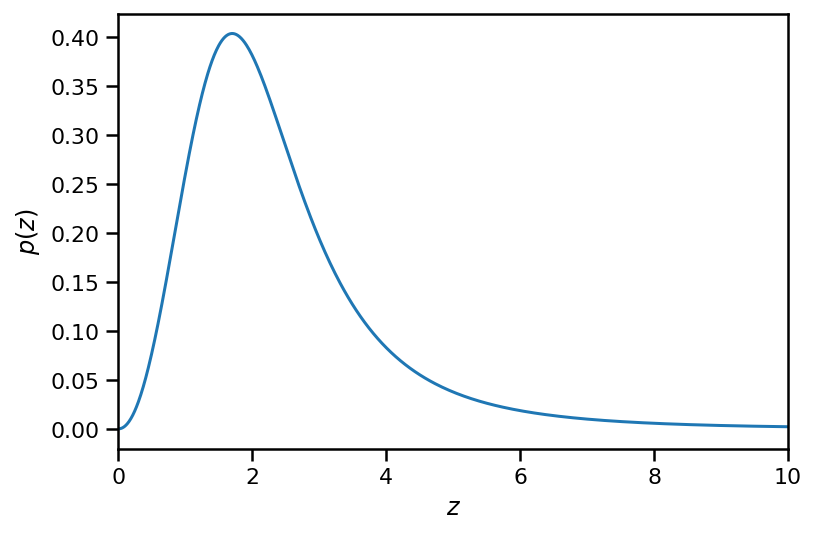

In [6]:
zi = expm1(linspace(log(1), log(1+100), 1024))
pz = (1+zi)**1.7/(1+((1+zi)/(1+1.9))**5.6)*cosmo.Planck18.differential_comoving_volume(zi).to(u.Gpc**3/u.sr)
cz = si.cumulative_trapezoid(pz, zi, initial=0)
plot(zi, pz/cz[-1])
axis(xmin=0, xmax=10)
xlabel(r'$z$')
ylabel(r'$p(z)$')

Now that we have $p(z)$ we draw `Nobs` sources (1000 sources takes a minute or two to analyze on my laptop, so choose accordingly) from the redshift distribution, and compute their luminosity distances.

Text(0.5, 8.95999999999998, '$z$')

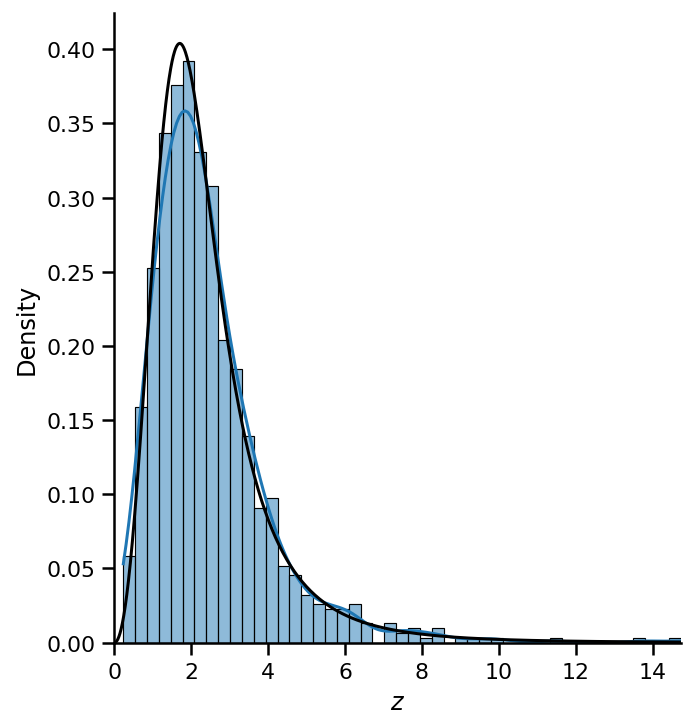

In [7]:
Nobs = 1000
zt = np.interp(np.random.uniform(low=0, high=cz[-1], size=Nobs), cz, zi)
dt = cosmo.Planck18.luminosity_distance(zt).to(u.Gpc).value
sns.displot(zt, kde=True, stat='density')
plot(zi, pz/cz[-1], color='k')
axis(xmin=0, xmax=max(zt))
xlabel(r'$z$')

Then we make mock observations of these sources.  We assume that the only uncertainty in the redshift comes from the width of the NS mass function, which we take to be approximately $\sigma_m / m \simeq 0.1$; we assume that the detector-frame mass is measured so well that it has effectively zero uncertainty.  Thus 
$$
\log m_\mathrm{det} = \log m + \log\left( 1 + z \right),
$$
and 
$$
\frac{\sigma_z}{1+z} \simeq \frac{\sigma_m}{m} \simeq 0.1.
$$

We assume that the *fractional* uncertainty on the amplitude of the signal, and therefore $\sigma_d / d$ scales inversely with SNR, reaching 30\% at $z \simeq 10$; thus 
$$
\frac{\sigma_d}{d} \simeq 0.3 \frac{d}{d\left( z = 10 \right)}.
$$
We place a lower limit on $\sigma_d / d \sim 0.1$ even at low distances to avoid the un-physical situation where we have $\sigma_d \to 0$.

In [8]:
d10 = cosmo.Planck18.luminosity_distance(10).to(u.Gpc).value
sigma_z = 0.1*(1 + zt)
sigma_d = 0.3*dt*(1/3 + dt/d10)
zo = zt + sigma_z*randn(Nobs)
do = dt + sigma_d*randn(Nobs)

Let's plot our measurements and truth:

Text(0, 0.5, '$d_L / \\mathrm{Gpc}$')

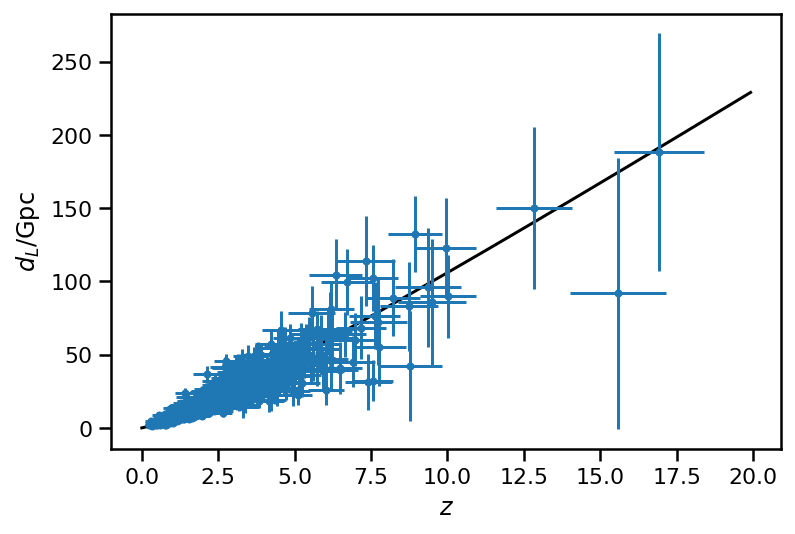

In [9]:
m = zi < 20
plot(zi[m], cosmo.Planck18.luminosity_distance(zi).to(u.Gpc).value[m], color='k')
errorbar(zo, do, xerr=sigma_z, yerr=sigma_d, fmt='.')
xlabel(r'$z$')
ylabel(r'$d_L / \mathrm{Gpc}$')

Now we construct the model, and fit it:

In [ ]:
with make_model(zo, sigma_z, do, sigma_d) as model:
    trace = pm.sample()

Let's just look at a summary of the cosmological variables.

In [11]:
with model:
    display(az.summary(trace, var_names=['h', 'Om', 'w']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h,0.743,0.050,0.648,0.838,0.002,0.001,623.0,1000.0,1.0
Om,0.285,0.047,0.198,0.372,0.002,0.001,594.0,951.0,1.0
w,-1.268,0.188,-1.500,-0.919,0.006,0.004,1077.0,1218.0,1.0


A traceplot is a good way to double-check that the sampling has converged:

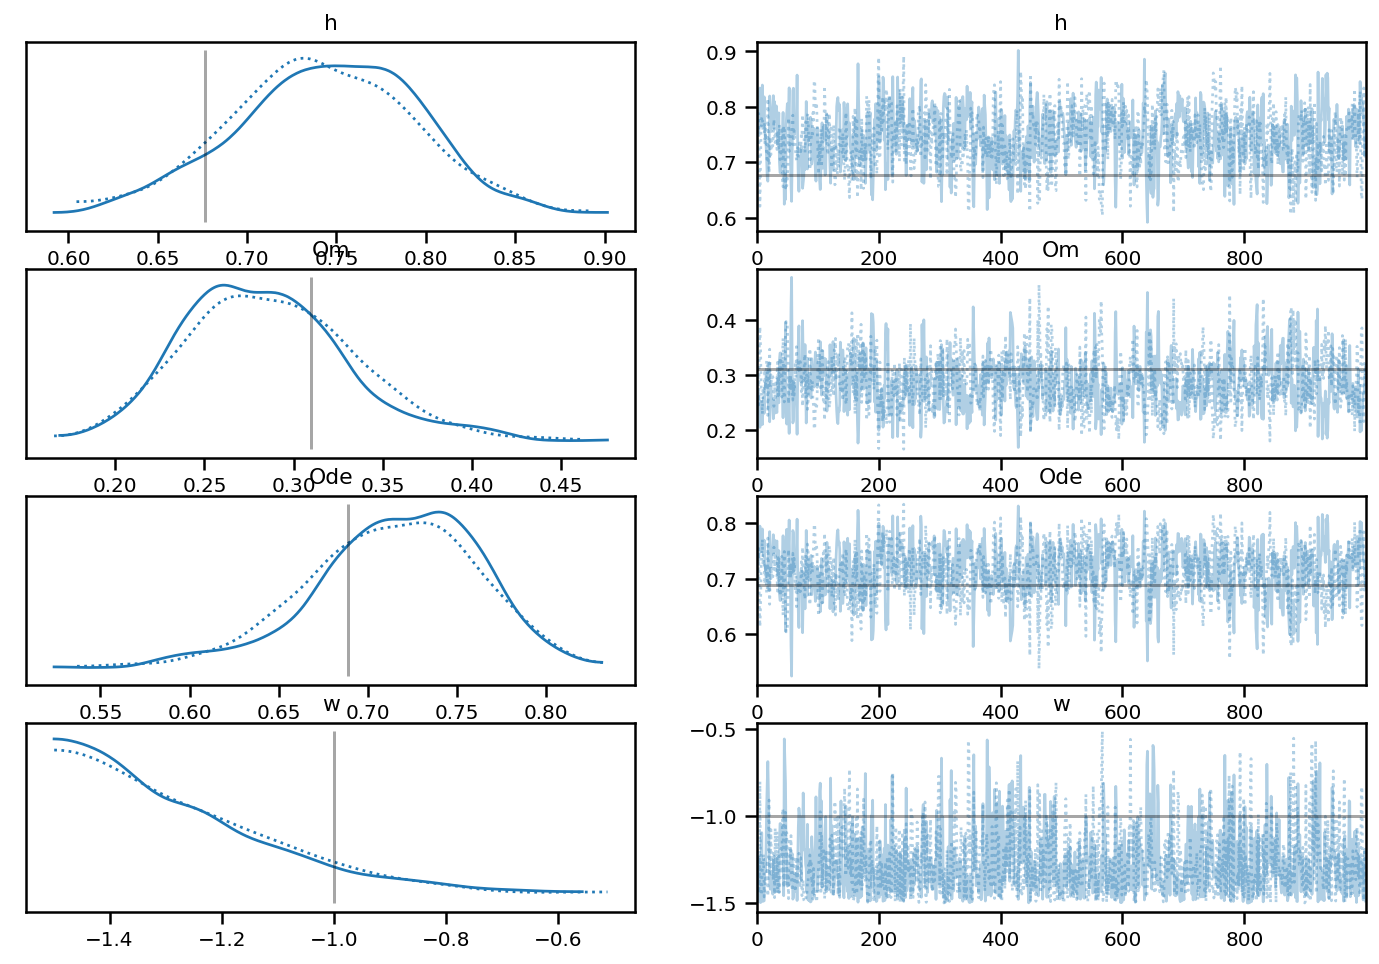

In [12]:
with model:
    az.plot_trace(trace, compact=True, var_names=['h', 'Om', 'Ode', 'w'],
                  lines=[('h', {}, cosmo.Planck18.H0/100),
                         ('Om', {}, cosmo.Planck18.Om0),
                         ('Ode', {}, cosmo.Planck18.Ode0),
                         ('w', {}, -1)])

Here we make a corner plot of the "natural" cosmological variables and the variables in which we sample (so the lower right 3x3 is the distribution that the sampler sees).  You can see that using $h\left(z = 0.5\right)$ helps a lot to de-correlate the cosmological parameters, which makes sampling easier.

array([[<AxesSubplot:ylabel='h'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Om'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='w'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='hz0.5'>,
        <AxesSubplot:xlabel='Om'>, <AxesSubplot:xlabel='w'>,
        <AxesSubplot:xlabel='hz0.5'>]], dtype=object)

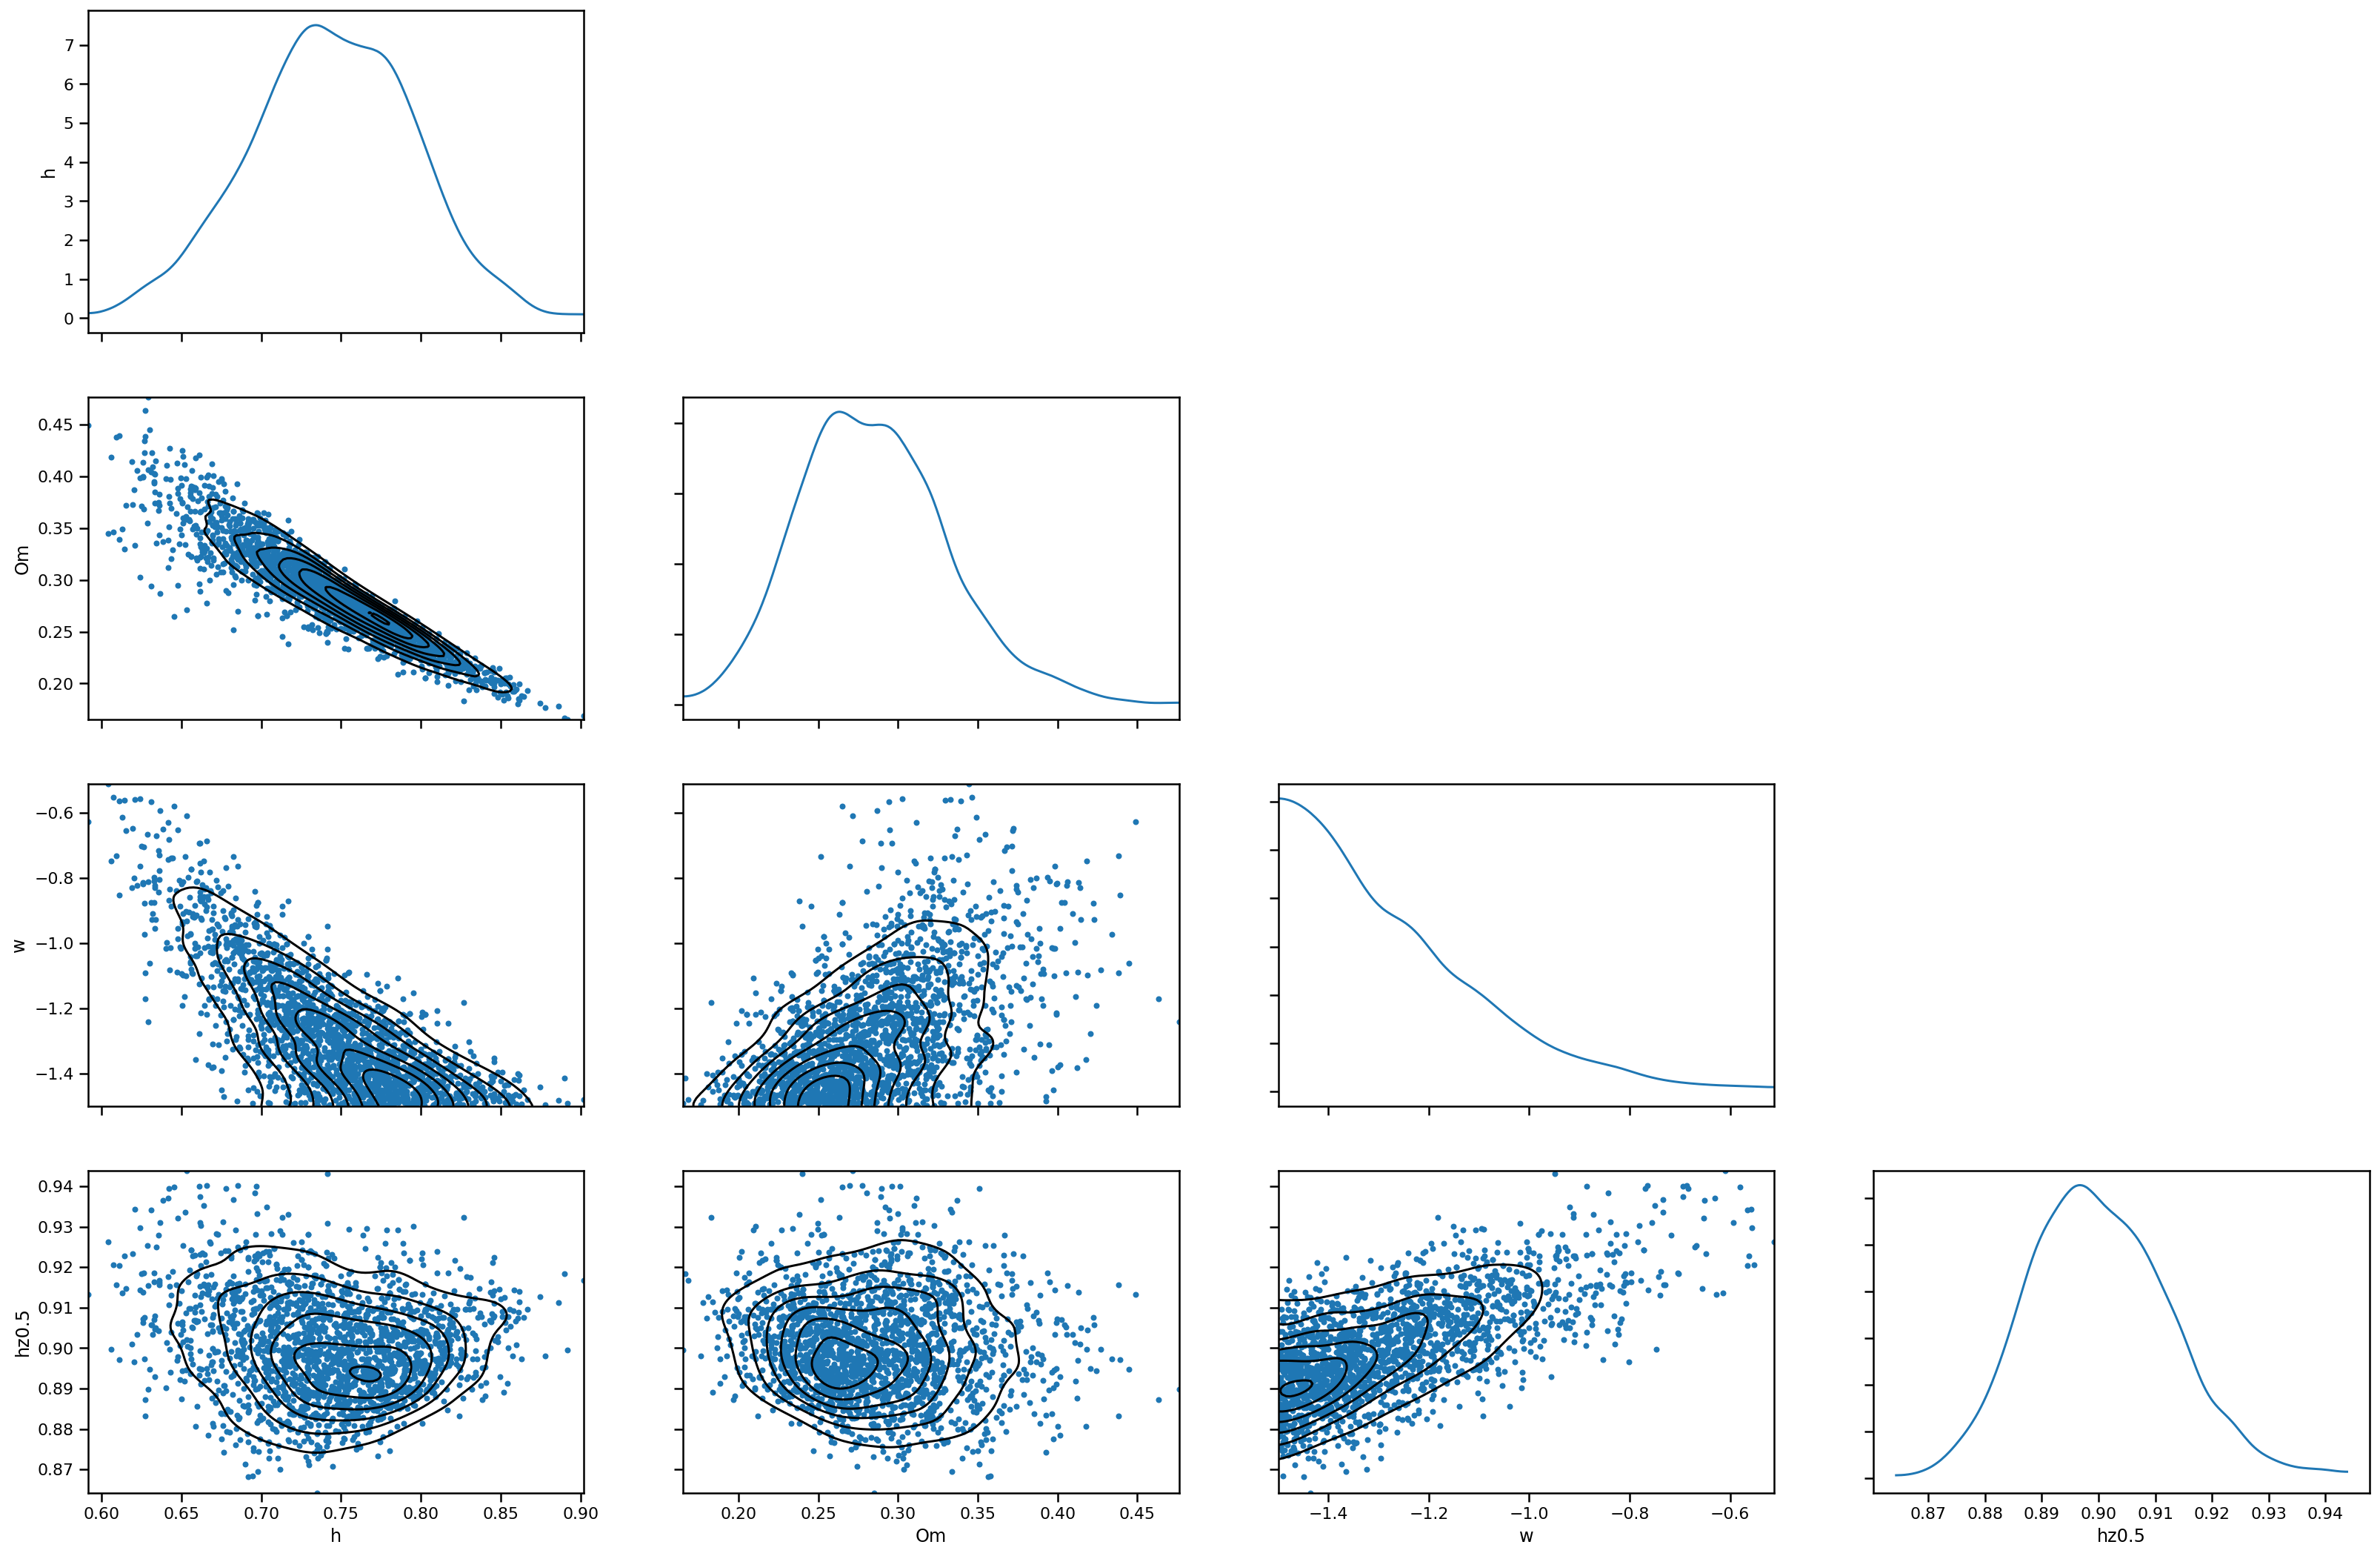

In [13]:
az.plot_pair(trace, var_names=['h', 'Om', 'w', 'hz0.5'], marginals=True, kind=['scatter', 'kde'], divergences=True)

If you just want the cosmological parameters:

array([[<AxesSubplot:ylabel='h'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='Om'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='h', ylabel='w'>, <AxesSubplot:xlabel='Om'>,
        <AxesSubplot:xlabel='w'>]], dtype=object)

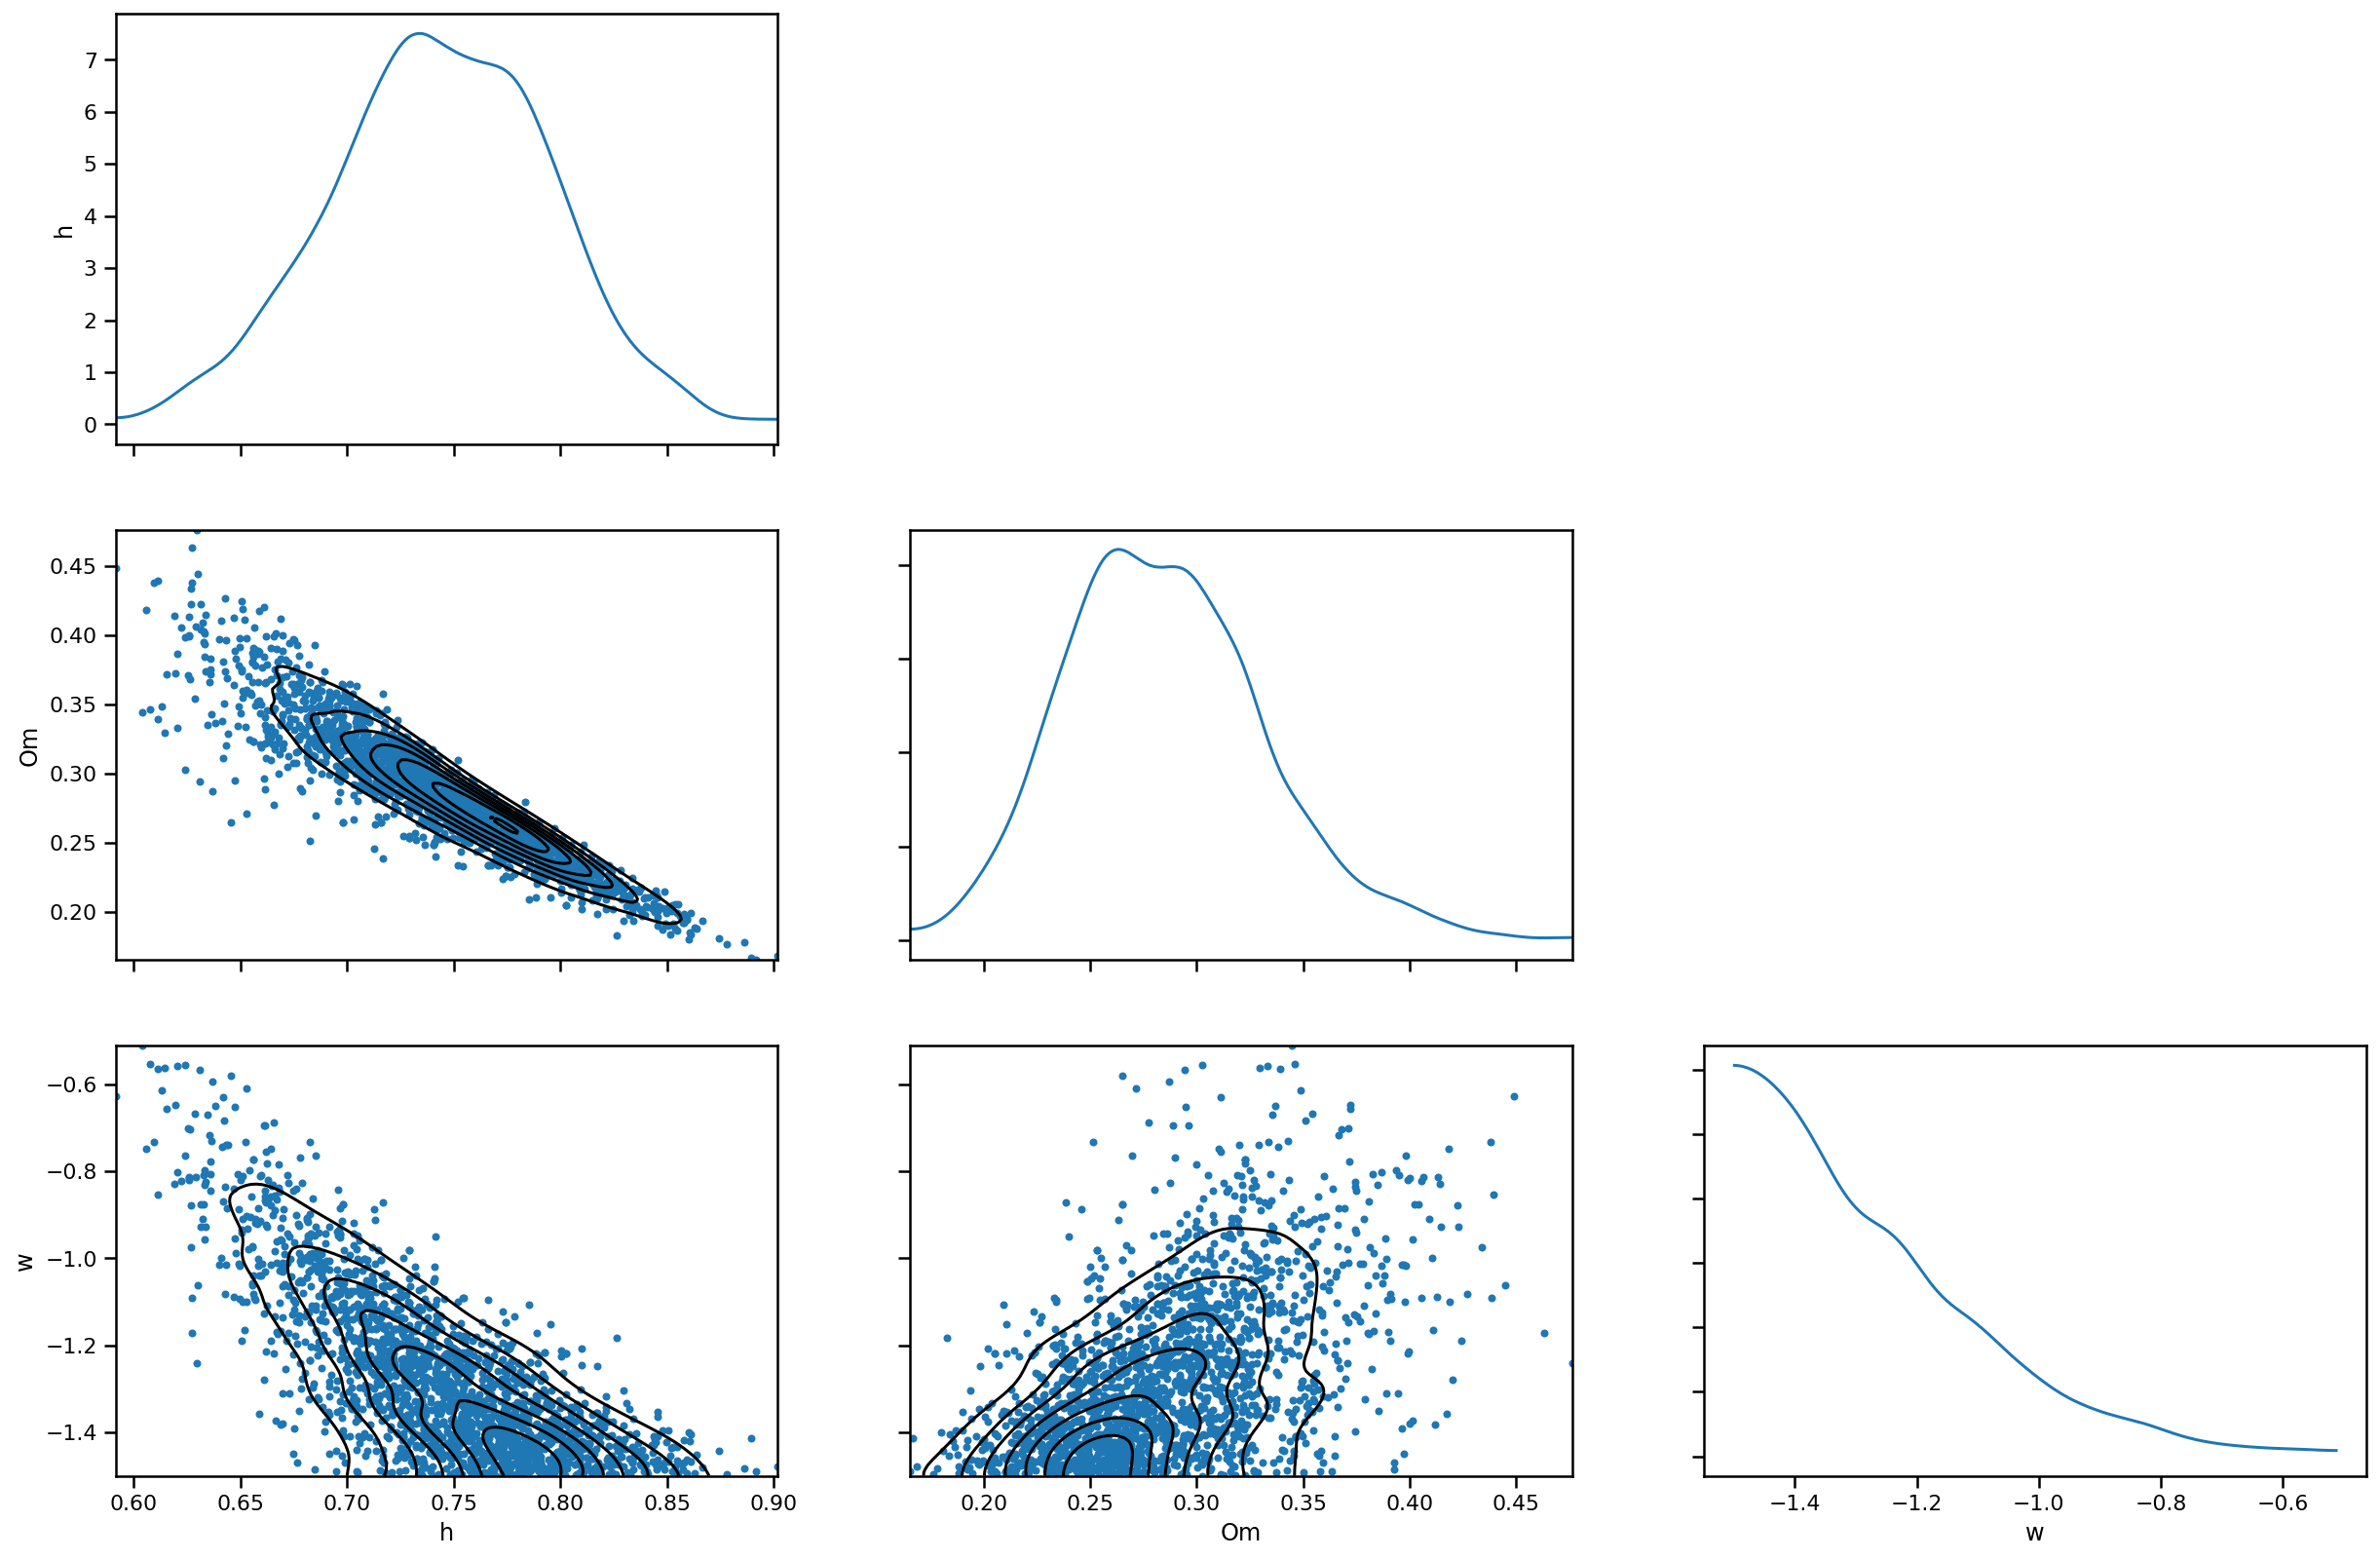

In [14]:
az.plot_pair(trace, var_names=['h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'], divergences=True)

We would like to make plots of $h(z) = h E\left( z \mid \Omega_M, w \right)$.  We can add this quantity to the stored chain using the following snippet; we add a new coordinate to the posterior dataset representing the interpolated values of $z$, and then produce $h(z)$ which has shape `(zinterp, chain, draw)` due to the `broadcast` call merging the coordinates of `h`, `Om` and `w` (`(chain, draw)`) with the coordinates of `zinterp` (`(zinterp,)`).

In [15]:
trace.posterior = trace.posterior.assign_coords(zinterp=zi)
post = trace.posterior
z = post.coords['zinterp']
h = post.h
Om = post.Om
w = post.w

h,Om,w,z = xr.broadcast(h, Om, w, z)
hz = h*Ez(array(z), array(Om), array(w)).eval()
post['hz'] = hz

We can make a plot of the posterior median, 1-, and 2-sigma intervals of $h(z)$; the "neck" at $z = 0.5$ is readily identified.

Text(0, 0.5, '$h(z)$')

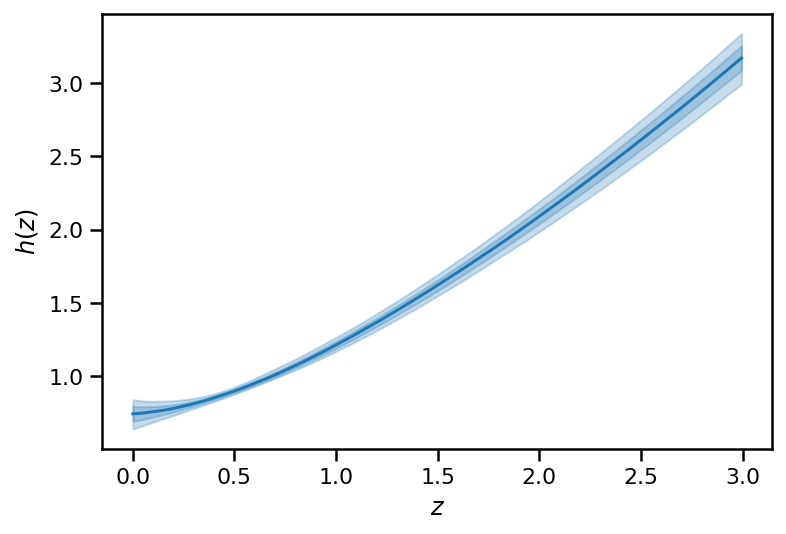

In [16]:
p = post.sel(zinterp=slice(0,3))
l, = plot(p.coords['zinterp'], p.hz.median(dim=['chain', 'draw']))
fill_between(p.coords['zinterp'], p.hz.quantile(0.84, dim=['chain', 'draw']), p.hz.quantile(0.16, dim=['chain', 'draw']), alpha=0.25, color=l.get_color())
fill_between(p.coords['zinterp'], p.hz.quantile(0.975, dim=['chain', 'draw']), p.hz.quantile(0.025, dim=['chain', 'draw']), alpha=0.25, color=l.get_color())
xlabel(r'$z$')
ylabel(r'$h(z)$')

Here is the standard deviation of $\log(h(z))$ versus $z$ (roughly the relative error in $z$), showing even more clearly the "neck" at $z = 0.5$.

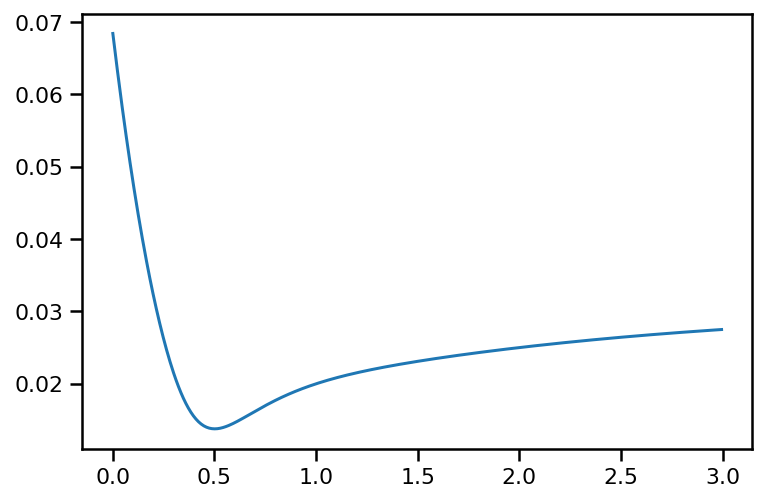

In [17]:
shz = log(p.hz).std(dim=['chain', 'draw'])
plot(p.coords['zinterp'], shz)

Let's look at the posterior inference on the distances and redshifts of our sources.  Because we enforce that all our sources follow the $z$-$d_L$ relation defined by the cosmology, they "snap" to the curve with much smaller uncertainty (since the cosmology allows to combine the precision of both measurements of $d_L$ and $z$).

Text(0, 0.5, '$d_L / \\mathrm{Gpc}$')

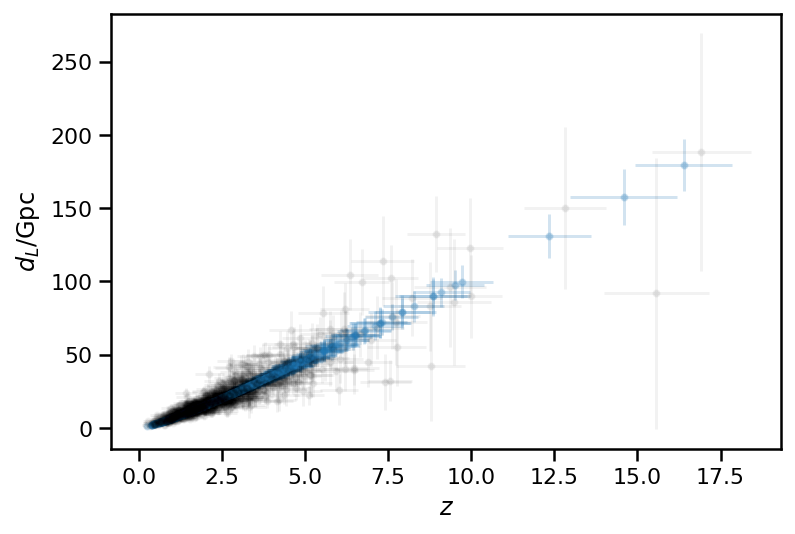

In [18]:
z = post.z
d = post.dL
dim = ['chain', 'draw']
errorbar(z.mean(dim=dim), d.mean(dim=dim), xerr=z.std(dim=dim), yerr=d.std(dim=dim), fmt='.', alpha=0.2, label='Posterior')
errorbar(zo, do, xerr=sigma_z, yerr=sigma_d, fmt='.', color='k', alpha=0.05, label='Observations')
xlabel(r'$z$')
ylabel(r'$d_L / \mathrm{Gpc}$')

Or, looking in $\log 1 + z$ and $\log d_L$:

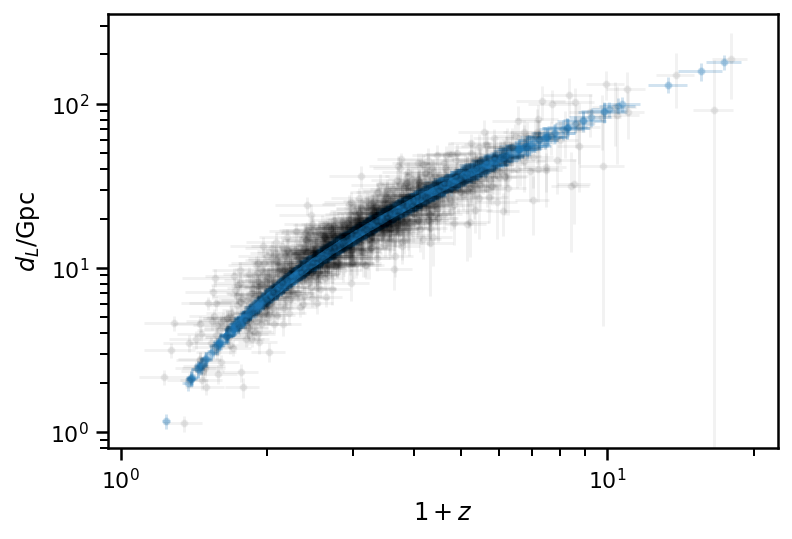

In [20]:
z = post.z
d = post.dL
dim = ['chain', 'draw']
errorbar(1+z.mean(dim=dim), d.mean(dim=dim), xerr=z.std(dim=dim), yerr=d.std(dim=dim), fmt='.', alpha=0.2, label='Posterior')
errorbar(1 + zo, do, xerr=sigma_z, yerr=sigma_d, fmt='.', color='k', alpha=0.05, label='Observations')
xlabel(r'$1 + z$')
ylabel(r'$d_L / \mathrm{Gpc}$')
xscale('log')
yscale('log')

One interesting thing to look at is the residuals: how close do the observations come to the fitted values, and is this consistent with the observational uncertainties?  This is a bit complicated here in 2D (the estimated value can be discrepant from the observations in both $d_L$ and $z$).  Below we plot for each observation
$$
\frac{1}{2} \chi^2 \equiv \frac{1}{2} \left[\left( \frac{\left\langle z \right\rangle - z_\mathrm{obs}}{\sigma_z}\right)^2 + \left( \frac{\left\langle d_L \right\rangle - d_{L,\mathrm{obs}}}{\sigma_d}\right)^2 \right]
$$
where the expectations are taken over the posterior for each variable.  Roughly speaking, $\left\langle \chi^2 \right\rangle \simeq 2$, so these quantities should scatter around 1:

Text(0, 0.5, '$\\chi^2$')

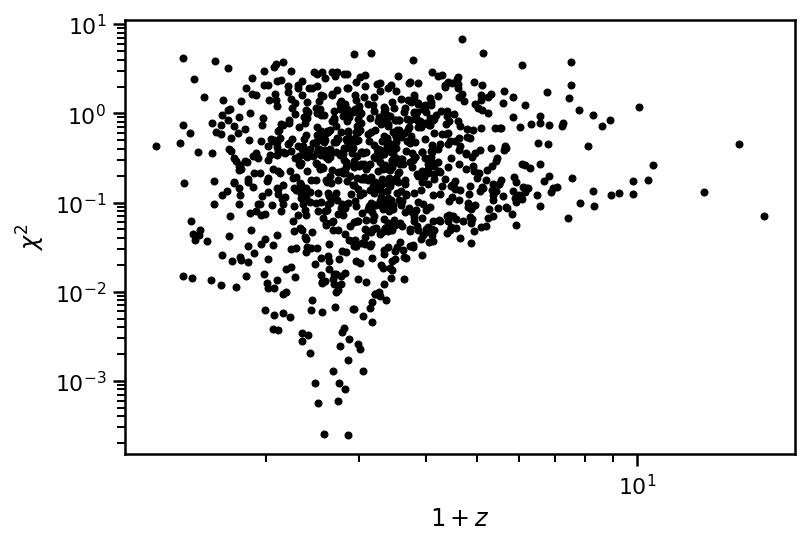

In [37]:
plot(1 + z.mean(dim=dim), 0.5*(np.square((z.mean(dim=dim).values-zo)/sigma_z) + np.square((d.mean(dim=dim).values-do)/sigma_d)), '.k')
xscale('log')
yscale('log')
xlabel(r'$1 + z$')
ylabel(r'$\chi^2$')

I don't know why the $\chi^2$ values get so low for a few observations around $z \simeq 2.75$, but maybe this is where the combination of lots of observations and errorbars becomes fortuitious.